In [1]:
import nbimporter
import myai as ai

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Importing Jupyter notebook from myai.ipynb


In [2]:
class tensor:
    adj = []
    total_id = 0
    e = 2.718281828459045
    n_samples = 'wait for assigned'
    
    def __init__(self, data, represent, torch_type='sample'):
        _dict = {}
        _dict['id'] = tensor.total_id
        _dict['data'] = data
        _dict['represent'] = represent
        _dict['torch_type'] = torch_type
        _dict['created_from'] = 'assigned'
        _dict['send_to'] = []
        _dict['diff'] = []
        _dict['family'] = set()
        _dict['storage_chain_rule'] = None
        if torch_type == 'sample' and tensor.n_samples == 'wait for assigned':
            tensor.n_samples = represent.shape[0]
        tensor.adj.append(_dict)
        self.id = tensor.total_id
        tensor.total_id += 1
        self.data = data
        
    @classmethod
    def clear_adj(self):
        tensor.adj = []
        tensor.total_id = 0
        tensor.n_samples = 'wait for assigned'
        
    def update_so(self, self_id, other_id, new_var_id, operation):
        tensor.adj[self_id]['send_to'].append(new_var_id)
        tensor.adj[other_id]['send_to'].append(new_var_id)
        tensor.adj[new_var_id]['created_from'] = operation
        
        self_set = tensor.adj[self_id]['family']
        other_set = tensor.adj[other_id]['family']
        tensor.adj[new_var_id]['family'].add(self_id)
        tensor.adj[new_var_id]['family'].add(other_id)
        tensor.adj[new_var_id]['family'] = tensor.adj[new_var_id]['family'] | self_set | other_set
        
    def update_s(self, self_id, new_var_id, operation):
        tensor.adj[self_id]['send_to'].append(new_var_id)
        tensor.adj[new_var_id]['created_from'] = operation
        
        self_set = tensor.adj[self_id]['family']
        tensor.adj[new_var_id]['family'].add(self_id)
        tensor.adj[new_var_id]['family'] = tensor.adj[new_var_id]['family'] | self_set
        
    def __add__(self, other):
        if isinstance(other, tensor):
            represent = tensor.adj[self.id]['represent'] + tensor.adj[other.id]['represent']
            new_var = tensor(self.data + other.data, represent)
            operation = ('+', self.id, other.id)
            self.update_so(self.id, other.id, new_var.id, operation)
            tensor.adj[self.id]['diff'].append(np.ones([tensor.n_samples, 1]))
            tensor.adj[other.id]['diff'].append(np.ones([tensor.n_samples, 1]))
        else:
            represent = tensor.adj[self.id]['represent'] + other
            new_var = tensor(self.data + other, represent)
            operation = ('+', self.id, str(other))
            self.update_s(self.id, new_var.id, operation)
            tensor.adj[self.id]['diff'].append(np.ones([tensor.n_samples, 1]))
        return new_var
    
    def __radd__(self, other):
        if not isinstance(other, tensor):
            represent = other + tensor.adj[self.id]['represent']
            new_var = tensor(other + self.data, represent)
            operation = ('+', str(other), self.id)
            self.update_s(self.id, new_var.id, operation)
            tensor.adj[self.id]['diff'].append(np.ones([tensor.n_samples, 1]))
        return new_var
    
    def __sub__(self, other):
        if isinstance(other, tensor):
            represent = tensor.adj[self.id]['represent'] - tensor.adj[other.id]['represent']
            new_var = tensor(self.data - other.data, represent)
            operation = ('-', self.id, other.id)
            self.update_so(self.id, other.id, new_var.id, operation)
            tensor.adj[self.id]['diff'].append(np.ones([tensor.n_samples, 1]))
            tensor.adj[other.id]['diff'].append(-np.ones([tensor.n_samples, 1]))
        else:
            represent = tensor.adj[self.id]['represent'] - other
            new_var = tensor(self.data - other, represent)
            operation = ('-', self.id, str(other))
            self.update_s(self.id, new_var.id, operation)
            tensor.adj[self.id]['diff'].append(np.ones([tensor.n_samples, 1]))
        return new_var
    
    def __rsub__(self, other):
        if not isinstance(other, tensor):
            represent = other - tensor.adj[self.id]['represent']
            new_var = tensor(other - self.data, represent)
            operation = ('-', str(other), self.id)
            self.update_s(self.id, new_var.id, operation)
            tensor.adj[self.id]['diff'].append(-np.ones([tensor.n_samples, 1]))
        return new_var
    
    def __mul__(self, other):
        if isinstance(other, tensor):
            represent = tensor.adj[self.id]['represent']*tensor.adj[other.id]['represent']
            new_var = tensor(self.data * other.data, represent)
            operation = ('*', self.id, other.id)
            self.update_so(self.id, other.id, new_var.id, operation)
            tensor.adj[self.id]['diff'].append(tensor.adj[other.id]['represent'])
            tensor.adj[other.id]['diff'].append(tensor.adj[self.id]['represent'])
        else:
            represent = tensor.adj[self.id]['represent']*other
            new_var = tensor(self.data * other, represent)
            operation = ('*', self.id, str(other))
            self.update_s(self.id, new_var.id, operation)
            tensor.adj[self.id]['diff'].append(other * np.ones([tensor.n_samples, 1]))
        return new_var
    
    def __rmul__(self, other):
        if not isinstance(other, tensor):
            represent = other*tensor.adj[self.id]['represent']
            new_var = tensor(other * self.data, represent)
            operation = ('*', str(other), self.id)
            self.update_s(self.id, new_var.id, operation)
            tensor.adj[self.id]['diff'].append(other * np.ones([tensor.n_samples, 1]))
        return new_var
    
    def __truediv__(self, other):
        if isinstance(other, tensor):
            represent = tensor.adj[self.id]['represent']/tensor.adj[other.id]['represent']
            new_var = tensor(self.data / other.data, represent)
            operation = ('/', self.id, other.id)
            self.update_so(self.id, other.id, new_var.id, operation)
            tensor.adj[self.id]['diff'].append(1/tensor.adj[other.id]['represent'])
            tensor.adj[other.id]['diff'].append(-tensor.adj[self.id]['represent']/tensor.adj[other.id]['represent']**2)
        else:
            represent = tensor.adj[self.id]['represent']/other
            new_var = tensor(self.data / other, represent)
            operation = ('/', self.id, str(other))
            self.update_s(self.id, new_var.id, operation)
            tensor.adj[self.id]['diff'].append((1/other) * np.ones([tensor.n_samples, 1]))
        return new_var
    
    def __rtruediv__(self, other):
        if not isinstance(other, tensor):
            represent = other / tensor.adj[self.id]['represent']
            new_var = tensor(other / self.data, represent)
            operation = ('/', str(other), self.id)
            self.update_s(self.id, new_var.id, operation)
            tensor.adj[self.id]['diff'].append(-other/tensor.adj[self.id]['represent']**2)
        return new_var
        
    def __pow__(self, other):
        if isinstance(other, tensor):
            represent = tensor.adj[self.id]['represent'] ** tensor.adj[other.id]['represent']
            new_var = tensor(self.data ** other.data, represent)
            operation = ('**', self.id, other.id)
            self.update_so(self.id, other.id, new_var.id, operation)
            self_rep = tensor.adj[self.id]['represent']
            other_rep = tensor.adj[other.id]['represent']
            tensor.adj[self.id]['diff'].append(other_rep*self_rep**(other_rep-1))
            tensor.adj[other.id]['diff'].append((self_rep**other_rep)*np.log(self_rep))
        else:
            represent = tensor.adj[self.id]['represent'] ** other
            new_var = tensor(self.data ** other, represent)
            operation = ('**', self.id, str(other))
            self.update_s(self.id, new_var.id, operation)
            self_rep = tensor.adj[self.id]['represent']
            tensor.adj[self.id]['diff'].append(other*self_rep**(other-1))
        return new_var
    
    def __rpow__(self, other):
        if not isinstance(other, tensor):
            represent = other ** tensor.adj[self.id]['represent']
            new_var = tensor(other ** self.data, represent)
            operation = ('**', str(other), self.id)
            self.update_s(self.id, new_var.id, operation)
            self_rep = tensor.adj[self.id]['represent']
            tensor.adj[self.id]['diff'].append((other**self_rep)*np.log(other))
        return new_var
    
    def __neg__(self):
        represent = -tensor.adj[self.id]['represent']
        new_var = tensor(-self.data, represent)
        operation = ('-1*', self.id)
        self.update_s(self.id, new_var.id, operation)
        tensor.adj[self.id]['diff'].append(-np.ones([tensor.n_samples, 1]))
        return new_var
    
    def __abs__(self):
        represent = np.abs(tensor.adj[self.id]['represent'])
        new_var = tensor(abs(self.data), represent)
        operation = ('abs', self.id)
        self.update_s(self.id, new_var.id, operation)
        diff_abs = (tensor.adj[self.id]['represent'] > 0) -1*(tensor.adj[self.id]['represent'] < 0)
        tensor.adj[self.id]['diff'].append(diff_abs * np.ones([tensor.n_samples, 1]))
        return new_var
    
    def log(self):
        represent = np.log(tensor.adj[self.id]['represent'])
        new_var = tensor(np.log(self.data), represent)
        operation =  ('log', self.id)
        self.update_s(self.id, new_var.id, operation)
        tensor.adj[self.id]['diff'].append(1/(tensor.adj[self.id]['represent']))
        return new_var
    
    def maximum(self, other):
        if isinstance(other, tensor):
            represent = np.maximum(tensor.adj[self.id]['represent'], tenor.adj[other.id]['represent'])
            new_var = tensor(np.maximum(self.data, other.data), represent)
            operation = ('maximum', self.id, other.id)
            self.update_so(self.id, other.id, new_var.id, operation)
            diff_self = (represent == tensnor.adj[self.id]['represent'])
            diff_other = (represent == tensor.adj[other.id]['represent'])
            tensor.adj[self.id]['diff'].append(diff_self)
            tensor.adj[other.id]['diff'].append(diff_other)
        else:
            represent = np.maximum(tensor.adj[self.id]['represent'], other)
            new_var = tensor(np.maximum(self.data, other), represent)
            operation = ('maximum', self.id, str(other))
            self.update_s(self.id, new_var.id, operation)
            diff_self = (represent == tensor.adj[self.id]['represent'])
            tensor.adj[self.id]['diff'].append(diff_self)
        return new_var
    
    def minimum(self, other):
        if isinstance(other, tensor):
            represent = np.minimum(tensor.adj[self.id]['represent'], tenor.adj[other.id]['represent'])
            new_var = tensor(np.minimum(self.data, other.data), represent)
            operation = ('minimum', self.id, other.id)
            self.update_so(self.id, other.id, new_var.id, operation)
            diff_self = (represent == tensnor.adj[self.id]['represent'])
            diff_other = (represent == tensor.adj[other.id]['represent'])
            tensor.adj[self.id]['diff'].append(diff_self)
            tensor.adj[other.id]['diff'].append(diff_other)
        else:
            represent = np.minimum(tensor.adj[self.id]['represent'], other)
            new_var = tensor(np.minimum(self.data, other), represent)
            operation = ('minimum', self.id, str(other))
            self.update_s(self.id, new_var.id, operation)
            diff_self = (represent == tensor.adj[self.id]['represent'])
            tensor.adj[self.id]['diff'].append(diff_self)
        return new_var

In [3]:
class torch(tensor):
    e = 2.718281828459045
    n_samples = 'wait for assigned'
    
    def __init__(self, data, torch_type='sample', assigned=False):
        self.data = data
        self.torch_type = torch_type
        if assigned == True:
            if torch_type == 'sample':
                self.rep = self.ele_to_tensor(data, torch_type)
                if torch.n_samples == 'wait for assigned':
                    torch.n_samples = data.shape[0]
            elif torch_type == 'weight':
                self.rep = self.ele_to_tensor(data, torch_type)
            elif torch_type == 'bias':
                self.rep = self.ele_to_tensor(data, torch_type)
        else:
            self.rep = 'wait for assigned'

    def ele_to_tensor(self, matrix, torch_type):
        if torch_type == 'sample':
            sample_matrix = matrix[:1, :]
            o_matrix = np.array(sample_matrix, dtype='object')
        elif torch_type != 'sample':
            o_matrix = np.array(matrix, dtype='object')
        n_rows, n_cols = o_matrix.shape
        for r in range(n_rows):
            for c in range(n_cols):
                if torch_type == 'sample':
                    o_matrix[r,c] = tensor(o_matrix[r,c], matrix[:,c:c+1], torch_type)
                elif torch_type != 'sample':
                    o_matrix[r,c] = tensor(o_matrix[r,c], 
                                    o_matrix[r,c]*np.ones([torch.n_samples, 1]), torch_type)
        return o_matrix
    
    @classmethod
    def ele_to_numeric(self, matrix):
        matrix = np.array(matrix, dtype='object')
        n_rows, n_cols = matrix.shape
        for r in range(n_rows):
            for c in range(n_cols):
                matrix[r,c] = matrix[r,c].data
        return matrix
            
    def dot(self, other):
        if isinstance(other, tensor):
            new_var = torch(np.dot(self.data, other.data))
            new_var.rep = np.dot(self.rep, other.rep)
        else:
            new_var = torch(np.dot(self.data, other))
            new_var.rep = np.dot(self.rep, other)
        return new_var
    
    def __add__(self, other):
        if isinstance(other, torch):
            new_var = torch(self.data + other.data)
            new_var.rep = self.rep + other.rep
        else:
            new_var = torch(self.data + other)
            new_var.rep = self.rep + other
        return new_var
    
    def __radd__(self, other):
        if not isinstance(other, torch):
            new_var = torch(other + self.data)
            new_var.rep = other + self.rep
        return new_var
    
    def __sub__(self, other):
        if isinstance(other, torch):
            new_var = torch(self.data - other.data)
            new_var.rep = self.rep - other.rep
        else:
            new_var = torch(self.data - other)
            new_var.rep = self.rep - other
        return new_var
            
    def __rsub__(self, other):
        if not isinstance(other, torch):
            new_var = torch(other - self.data)
            new_var.rep = other - self.rep
        return new_var
    
    def __mul__(self, other):
        if isinstance(other, torch):
            new_var = torch(self.data * other.data)
            new_var.rep = self.rep * other.rep
        else:
            new_var = torch(self.data * other)
            new_var.rep = self.rep * other
        return new_var
    
    def __rmul__(self, other):
        if not isinstance(other, torch):
            new_var = torch(other * self.data)
            new_var.rep = other * self.rep
        return new_var
    
    def __truediv__(self, other):
        if isinstance(other, torch):
            new_var = torch(self.data / other.data)
            new_var.rep = self.rep / other.rep
        else:
            new_var = torch(self.data / other)
            new_var.rep = self.rep / other
        return new_var
        
    def __rtruediv__(self, other):
        if not isinstance(other, torch):
            new_var = torch(other / self.data)
            new_var.rep = other / self.rep
        return new_var
    
    def __pow__(self, other):
        if isinstance(other, torch):
            new_var = torch(self.data ** other.data)
            new_var.rep = self.rep ** other.rep
        else:
            new_var = torch(self.data ** other)
            new_var.rep = self.rep ** other
        return new_var
    
    def __rpow__(self, other):
        if not isinstance(other, torch):
            new_var = torch(other ** self.data)
            new_var.rep = other ** self.rep
        return new_var
    
    def __neg__(self):
        new_var = torch(-self.data)
        new_var.rep = -self.rep
        return new_var
    
    def abs(self):
        new_var = torch(np.abs(self.data))
        new_var.rep = np.abs(self.rep)
        return new_var
    
    def log(self):
        new_var = torch(np.log(self.data))
        new_var.rep = np.log(self.rep)
        return new_var

    def maximum(self, other):
        if isinstance(self, torch):
            if isinstance(other, torch):
                new_var = torch(np.maximum(self.data, other.data))
                n_rows, n_cols = self.rep.shape
                max_matrix = np.zeros([n_rows, n_cols], dtype='object')
                for r in range(n_rows):
                    for c in range(n_cols):
                        max_tensor = tensor.maximum(self.rep[r,c], other.rep[r,c])
                        max_matrix[r,c] = max_tensor
                new_var.rep = max_matrix
            else:
                new_var = torch(np.maximum(self.data, other))
                n_rows, n_cols = self.rep.shape
                max_matrix = np.zeros([n_rows, n_cols], dtype='object')
                for r in range(n_rows):
                    for c in range(n_cols):
                        max_tensor = tensor.maximum(self.rep[r,c], other)
                        max_matrix[r,c] = max_tensor
                new_var.rep = max_matrix
        else:
            if isinstance(other, torch):
                new_var = torch(np.maximum(self, other.data))
                n_rows, n_cols = other.rep.shape
                max_matrix = np.zeros([n_rows, n_cols], dtype='object')
                for r in range(n_rows):
                    for c in range(n_cols):
                        max_tensor = tensor.maximum(other.rep[r,c], self)
                        max_matrix[r,c] = max_tensor
                new_var.rep = max_matrix
            else:
                new_var = torch(np.maximum(self, other))
        return new_var
    
    def minimum(self, other):
        if isinstance(self, torch):
            if isinstance(other, torch):
                new_var = torch(np.minimum(self.data, other.data))
                n_rows, n_cols = self.rep.shape
                min_matrix = np.zeros([n_rows, n_cols], dtype='object')
                for r in range(n_rows):
                    for c in range(n_cols):
                        min_tensor = tensor.minimum(self.rep[r,c], other.rep[r,c])
                        min_matrix[r,c] = min_tensor
                new_var.rep = min_matrix
            else:
                new_var = torch(np.minimum(self.data, other))
                n_rows, n_cols = self.rep.shape
                min_matrix = np.zeros([n_rows, n_cols], dtype='object')
                for r in range(n_rows):
                    for c in range(n_cols):
                        min_tensor = tensor.minimum(self.rep[r,c], other)
                        min_matrix[r,c] = min_tensor
                new_var.rep = min_matrix
        else:
            if isinstance(other, torch):
                new_var = torch(np.minimum(self, other.data))
                n_rows, n_cols = other.rep.shape
                min_matrix = np.zeros([n_rows, n_cols], dtype='object')
                for r in range(n_rows):
                    for c in range(n_cols):
                        min_tensor = tensor.minimum(other.rep[r,c], self)
                        min_matrix[r,c] = min_tensor
                new_var.rep = min_matrix
            else:
                new_var = torch(np.maximum(self, other))
        return new_var

    def relu(self):
        relu = torch.maximum(self, 0)
        return relu
    
    def prelu(self, alpha):
        prelu = torch.maximum(self, 0) + alpha*torch.minimum(self, 0)
        return prelu
    
    def sigmoid(self):
        sigmoid = 1/(1 + torch.e**(-self))
        return sigmoid
    
    def tanh(self):
        tanh = (torch.e**self - torch.e**(-self))/(torch.e**self + torch.e**(-self))
        return tanh
    
    def softmax(self):
        eZ = torch.e**self
        denominator = torch.col_sum(eZ)
        softmax = eZ/denominator
        return softmax
    
    def col_sum(self):
        new_var = torch(np.sum(self.data, axis=1, keepdims=True))
        new_var.rep = np.sum(self.rep, axis=1, keepdims=True)
        return new_var
    
    def sum(self):
        new_var = torch(np.sum(self.data))
        new_var.rep = np.sum(self.rep)
        return new_var
    
    def mean(self):
        new_var = torch(np.mean(self.data))
        new_var.rep = np.mean(self.rep)
        return new_var
    
    def sse(self, other):
        error = (self - other)**2
        sse = torch.sum(error)
        return sse
    
    def mse(self, other):
        error = (self - other)**2
        mse = torch.mean(error)
        return mse
    
    def m2_entropy(self, other):
        error = -(self*np.log(other+np.finfo(np.float32).eps) + (1-self)*np.log(1-other+np.finfo(np.float32).eps))
        entropy = torch.sum(error)
        return entropy
    
    def m_entropy(self, other):
        error = self*np.log(other+np.finfo(np.float32).eps)
        entropy = torch.mean(error)
        return entropy

#     def m2_entropy(self, other):
#         error = -(self*np.log(other+0.01) + (1-self)*np.log(1-other+0.01)
#         entropy = torch.sum(error)
#         return entropy
    
#     def m_entropy(self, other):
#         error = self*np.log(other+0.01)
#         entropy = torch.mean(error)
#         return entropy
    
    @classmethod
    def forward_diff(self, y_id, x_id):
        if (x_id in tensor.adj[y_id]['family']) or (x_id == y_id):
            if tensor.adj[x_id]['storage_chain_rule'] is not None:
                return tensor.adj[x_id]['storage_chain_rule']
            else:
                send_to = tensor.adj[x_id]['send_to']
                n_send = len(send_to)
                if n_send == 1:
                    target_id = send_to[0]
                    dy_dx = tensor.adj[x_id]['diff'][0] * self.forward_diff(y_id, target_id)
                    tensor.adj[x_id]['storage_chain_rule'] = dy_dx
                    return dy_dx
                elif n_send > 1:
                    dy_dx = 0
                    for i in range(n_send):
                        target_id = send_to[i]
                        dy_dx += tensor.adj[x_id]['diff'][i] * self.forward_diff(y_id, target_id)
                    tensor.adj[x_id]['storage_chain_rule'] = dy_dx
                    return dy_dx
                elif n_send == 0:
                    return 1
        else:
            return 0
    
    def gradient(self):
        n_rows, n_cols = self.rep.shape
        diff_matrix = np.zeros([n_rows, n_cols])
        for r in range(n_rows):
            for c in range(n_cols):
                diff_matrix[r,c] = np.sum(torch.forward_diff(tensor.adj[-1]['id'], self.rep[r,c].id))
        return diff_matrix

In [4]:
XX1 = np.random.randn(50, 3)
XX2 = np.random.randn(50, 3) + 4

In [5]:
Y1 = np.zeros([50, 1])
Y2 = np.ones([50, 1])

In [6]:
X0 = np.vstack([XX1, XX2])
W1 = np.random.randn(3, 1)
B1 = np.random.randn(1, 1)
Y = np.vstack([Y1, Y2])

In [7]:
epoch = 1000
lr = 0.1
loss_list = []
for i in range(epoch):
    t_X0 = torch(X0, torch_type='sample', assigned=True)
    t_W1 = torch(W1, torch_type='weight', assigned=True)
    t_B1 = torch(B1, torch_type='bias', assigned=True)
    t_Y = torch(Y, torch_type='sample', assigned=True)
    
    t_Z = torch.dot(t_X0, t_W1) + t_B1
    t_Yhat = torch.sigmoid(t_Z)
    loss = torch.m2_entropy(t_Y, t_Yhat) + 0.01*torch.sum(torch.abs(t_W1)) + 0.01*torch.sum(torch.abs(t_B1))
    loss_list.append(loss.data)
    
    dW1 = torch.gradient(t_W1)
    dB1 = torch.gradient(t_B1)
    W1 -= lr*dW1
    B1 -= lr*dB1
    
    torch.clear_adj()

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

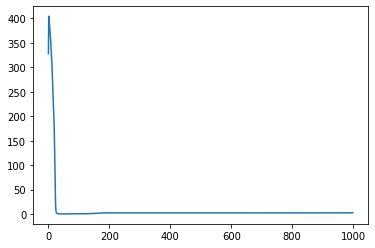

In [9]:
plt.plot(loss_list)

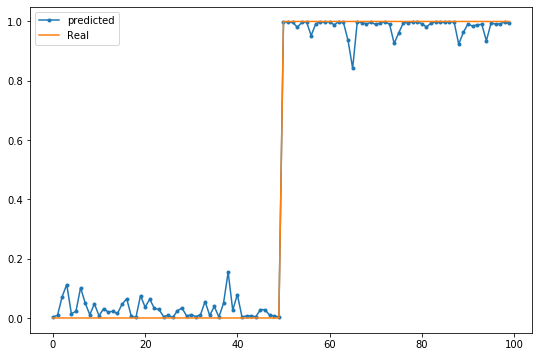

In [10]:
fig = plt.figure(figsize = (9, 6))
plt.plot(t_Yhat.data, '.-', label='predicted')
plt.plot(t_Y.data, label='Real')
plt.legend()